# Load libraries

In [290]:
%matplotlib inline

import os
import math

import configparser

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import sys
sys.path.append('../..')

from scripps.utils import read_datasets, norm1d, bayesian_linear_regression

import seaborn as sns

In [291]:
include_NER = True

In [292]:
CF = read_datasets.get_configuration()
cs_annotator_names = [key for key in dict(CF.items('m2c_citizen_disease')).keys() if key!='path']
cs_annotator_names.sort()
annotator_names = cs_annotator_names 
if include_NER:
    annotator_names = annotator_names + ['NER_expert']

In [293]:
all_labels = ['Disease', 'Phenotype', 'Both', 'None']

# Load "expert" annotations

In [294]:
def read_expert_disease_annotations():
    annotations = pd.DataFrame()
    anno = read_datasets.load_dataset('m2c_expert_disease', 'file')
    anno = anno[[0, 2]]
    anno[2].replace(['I-Disease', 'O', 'B-Disease', 'U-Disease', 'L-Disease'], [1, 0, 1, 1, 1], inplace=True)
    annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
    annotations = pd.concat([annotations, anno[2].rename('NER_expert')], axis=1)
    return annotations

def read_expert_phenotype_annotations():
    annotations = pd.DataFrame()
    anno = read_datasets.load_dataset('m2c_expert_phenotype', 'file')
    anno = anno[[0, 2]]
    anno[2].replace(['I-phenotype', 'O', 'B-phenotype', 'L-phenotype', 'U-phenotype'], [1, 0, 1, 1, 1], inplace=True)
    annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
    annotations = pd.concat([annotations, anno[2].rename('NER_expert')], axis=1)
    return annotations

def read_expert_mixed_annotations(disease_annotations, phenotype_annotations):
    mixed = [disease_annotations['NER_expert'] == 1][0].replace([True, False], [1, 0]) + \
    [phenotype_annotations['NER_expert'] == 1][0].replace([True, False], [2, 0])
    mixed_annotations = pd.DataFrame()
    mixed_annotations = pd.concat([mixed_annotations, disease_annotations['Token']], axis=1)
    mixed_annotations = pd.concat([mixed_annotations, mixed.replace([0, 1, 2, 3], ['O', 'I-Disease', 'I-Phenotype', 'I-Disease_Pheno'])], axis=1)
    return mixed_annotations
    

In [295]:
expert_disease_annotations = read_expert_disease_annotations()
expert_phenotype_annotations = read_expert_phenotype_annotations()
expert_annotations = read_expert_mixed_annotations(expert_disease_annotations, expert_phenotype_annotations)

# Load all mark2cure citizen scientist annotations

In [296]:
CF = read_datasets.get_configuration()

def read_disease_annotations():
    annotations = pd.DataFrame()
    idx = 0
    for anno_name in cs_annotator_names:
        anno = read_datasets.load_dataset('m2c_citizen_disease', anno_name)
        anno[3].replace(['I-Disease', 'O'], [1, 0], inplace=True)
        if idx == 0:
            annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
            idx += 1
        annotations = pd.concat([annotations, anno[3].rename(anno_name)], axis=1)
    return annotations

def read_phenotype_annotations():
    annotations = pd.DataFrame()
    idx = 0
    for anno_name in cs_annotator_names:
        anno = read_datasets.load_dataset('m2c_citizen_phenotype', anno_name)
        anno[3].replace(['I-Phenotype', 'O'], [1, 0], inplace=True)
        if idx == 0:
            annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
            idx += 1
        annotations = pd.concat([annotations, anno[3].rename(anno_name)], axis=1)
    return annotations

# Load original annotations

In [297]:
def read_both_annotations():
    annotations = pd.DataFrame()
    idx = 0
    for anno_name in cs_annotator_names:
        anno = read_datasets.load_dataset('m2c', anno_name)
        anno[3].replace(['I-?', 'I-Disease_Phen', 'I-Gene'], ['O', 'I-Disease_Pheno', 'O'], inplace=True)
        anno[3].replace(['I-Disease', 'I-Phenotype', 'I-Disease_Pheno', 'O'], \
                        ['Disease', 'Phenotype', 'Both', 'None'], inplace=True)
        if idx == 0:
            annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
            idx += 1
        annotations = pd.concat([annotations, anno[3].rename(anno_name)], axis=1)
    return annotations

def sanity_check(annotations, columns, values):
    for col in columns:
        assert set(annotations[col].unique()) == set(values)


In [298]:
disease_annotations = read_disease_annotations()
phenotype_annotations = read_phenotype_annotations()

In [299]:
mixed_annotations = read_both_annotations()
sanity_check(mixed_annotations, cs_annotator_names, all_labels)

In [300]:
if include_NER:
    mixed_annotations = pd.concat([mixed_annotations, expert_annotations['NER_expert']], axis=1)
    disease_annotations = pd.concat([disease_annotations, expert_disease_annotations['NER_expert']], axis=1)
    phenotype_annotations = pd.concat([phenotype_annotations, expert_phenotype_annotations['NER_expert']], axis=1)

In [301]:
mixed_annotations

,Token,m2c1,m2c2,m2c3,m2c5,m2c6_1st,m2c6_2nd,NER_expert
0,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,Both,I-Disease
1,and,None,None,None,None,None,None,O
2,abdominal,Disease,Disease,Disease,Both,Disease,Disease,I-Disease_Pheno
3,aortic,Disease,Disease,Disease,Both,Disease,Disease,I-Disease_Pheno
4,aneurysm,Disease,Disease,Disease,Both,Disease,Disease,I-Disease_Pheno
5,.,None,None,None,None,None,None,O
6,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,Both,I-Disease
7,and,None,None,None,None,None,None,O
8,left,Phenotype,Phenotype,None,None,Both,Phenotype,I-Disease_Pheno
9,loin,Phenotype,Phenotype,None,Phenotype,Both,Phenotype,I-Disease_Pheno


# Filter relevant rows

In [302]:
def get_relevant_rows(annotations):
    relevant = annotations[annotator_names] != 'None'
    relevant = annotations[relevant.all(axis=1)]
    #relevant = annotations[~(annotations[['Annotator1', 'Annotator2', 'Annotator3', 'Annotator4', 'Annotator5']] == 'O').all(axis=1)]
    return relevant

In [303]:
relevant_annotations = get_relevant_rows(mixed_annotations)

In [304]:
disease_annotations = disease_annotations.iloc[relevant_annotations.index]
phenotype_annotations = phenotype_annotations.iloc[relevant_annotations.index]

In [305]:
#disease_annotations = disease_annotations.reset_index()
#phenotype_annotations = phenotype_annotations.reset_index()

# Initialize latent variables

In [306]:
K = disease_annotations.shape[0]
J = disease_annotations.shape[1] - 1

latent = {}

latent['theta'] = np.zeros(K)
latent['d_alpha'] = np.zeros(J)
latent['d_beta'] = np.zeros(J)
latent['d_z'] = np.zeros((K, J))

latent['p_alpha'] = np.zeros(J)
latent['p_beta'] = np.zeros(J)
latent['p_z'] = np.zeros((K, J))

#Should these be separate for disease and phenotype?
latent['b0'] = np.zeros(2)
latent['B0_scale'] = 1
latent['m0'] = np.zeros(K) #TODO: ask HS regarding changing certain values here.
latent['C0_scale'] = 1

latent['K'] = K
latent['J'] = J

# Define functions for resampling using Gibbs sampling

In [307]:
def __get_alpha_beta_z(mode):
    if mode == 'disease':
        alpha = latent['d_alpha']
        beta = latent['d_beta']
        z = latent['d_z']
    else:
        alpha = latent['p_alpha']
        beta = latent['p_beta']
        z = latent['p_z']
    return alpha, beta, z
    

In [308]:
def __resample_z(alpha, beta, z, annotations):
    interval = [-100, 100] #Should this be changed?
    for k in range(K):
    #for k in annotations.index:
        for j in range(J):
            mean = alpha[j] + beta[j]*latent['theta'][k]
            std_dev = 1
            '''
            if(annotations['Annotator{}'.format(j+1)][k] == 0):
                z[k, j] = norm1d.truncnormal(mean, std_dev, interval[0], 0)
            elif(annotations['Annotator{}'.format(j+1)][k] == 1):
                z[k, j] = norm1d.truncnormal(mean, std_dev, 0, interval[1])
            '''
            if(annotations[annotator_names[j]][annotations.index[k]] == 0):
                z[k, j] = norm1d.truncnormal(mean, std_dev, interval[0], 0)
            elif(annotations[annotator_names[j]][annotations.index[k]] == 1):
                z[k, j] = norm1d.truncnormal(mean, std_dev, 0, interval[1])
    
def resample_z(mode):
    alpha, beta, z = __get_alpha_beta_z(mode)
    if mode == 'disease':
        annotations = disease_annotations
    else:
        annotations = phenotype_annotations
    __resample_z(alpha, beta, z, annotations)

In [309]:
def __resample_alpha_beta(alpha, beta, z):
    for j in range(J):
        Y = z[:, j]
        X = np.vstack((np.ones(K), latent['theta'])).T
        
        WN, VN = bayesian_linear_regression.linreg_post(X, Y, latent['b0'], latent['B0_scale'], 1)
        sample = np.random.multivariate_normal(WN, VN)
        alpha[j] = sample[0]
        beta[j] = sample[1]

def resample_alpha_beta(mode):
    alpha, beta, z = __get_alpha_beta_z(mode)
    __resample_alpha_beta(alpha, beta, z)

In [310]:
def resample_theta():
    for k in range(K):
        #Y = latent['d_z'][k, :] - latent['d_alpha'] + latent['p_z'][k, :] - latent['p_alpha']
        #X = latent['d_beta'] + latent['p_beta']
        Y = np.concatenate(((latent['d_z'][k, :] - latent['d_alpha']), (latent['p_z'][k, :] - latent['p_alpha'])), axis=0)
        X = np.concatenate((latent['d_beta'], latent['p_beta']), axis=0)
        X = np.reshape(X, (-1, 1))
        WN, VN = bayesian_linear_regression.linreg_post(X, Y, latent['m0'][k], latent['C0_scale'], 1)
        latent['theta'][k] = np.random.normal(WN, math.sqrt(VN))

In [311]:
def save_latent_variables():
    #TODO: save to csv.
    pass


def resample():
    resample_z('disease')
    resample_z('phenotype')
    resample_theta()
    resample_alpha_beta('disease')
    resample_alpha_beta('phenotype')
    
    save_latent_variables()
    
def has_converged():
    #TODO
    pass
    
def run_sampling(num_iter, thresh, print_freq=50):
    thetas = []
    d_alphas = []
    d_betas = []
    p_alphas = []
    p_betas = []
    for it in xrange(1, num_iter+1):
        resample()
        if it%print_freq == 0:
            print 'Iter {}/{} done.'.format(it, num_iter)
        if has_converged():
            break
        if it > thresh:
            thetas.append(np.array(latent['theta']))
            d_alphas.append(np.array(latent['d_alpha']))
            p_alphas.append(np.array(latent['p_alpha']))
            d_betas.append(np.array(latent['d_beta']))
            p_betas.append(np.array(latent['p_beta']))

    all_values = {}
    all_values['thetas'] = thetas
    all_values['d_alphas'] = d_alphas
    all_values['d_betas'] = d_betas
    all_values['p_alphas'] = p_alphas
    all_values['p_betas'] = p_betas
    
    return all_values

def get_averages(all_values, num_iter, thresh):
    avg_values = {}
    avg_values['theta'] = np.sum(all_values['thetas'], axis=0)/(num_iter - thresh)
    avg_values['d_alpha'] = np.sum(all_values['d_alphas'], axis=0)/(num_iter - thresh)
    avg_values['d_beta'] = np.sum(all_values['d_betas'], axis=0)/(num_iter - thresh)
    avg_values['p_alpha'] = np.sum(all_values['p_alphas'], axis=0)/(num_iter - thresh)
    avg_values['p_beta'] = np.sum(all_values['p_betas'], axis=0)/(num_iter - thresh)
    return avg_values

In [312]:
np.random.seed(23)
num_iter = 2000
thresh = 300
all_values = run_sampling(num_iter, thresh)
avg_values = get_averages(all_values, num_iter, thresh)

Iter 50/2000 done.
Iter 100/2000 done.
Iter 150/2000 done.
Iter 200/2000 done.
Iter 250/2000 done.
Iter 300/2000 done.
Iter 350/2000 done.
Iter 400/2000 done.
Iter 450/2000 done.
Iter 500/2000 done.
Iter 550/2000 done.
Iter 600/2000 done.
Iter 650/2000 done.
Iter 700/2000 done.
Iter 750/2000 done.
Iter 800/2000 done.
Iter 850/2000 done.
Iter 900/2000 done.
Iter 950/2000 done.
Iter 1000/2000 done.
Iter 1050/2000 done.
Iter 1100/2000 done.
Iter 1150/2000 done.
Iter 1200/2000 done.
Iter 1250/2000 done.
Iter 1300/2000 done.
Iter 1350/2000 done.
Iter 1400/2000 done.
Iter 1450/2000 done.
Iter 1500/2000 done.
Iter 1550/2000 done.
Iter 1600/2000 done.
Iter 1650/2000 done.
Iter 1700/2000 done.
Iter 1750/2000 done.
Iter 1800/2000 done.
Iter 1850/2000 done.
Iter 1900/2000 done.
Iter 1950/2000 done.
Iter 2000/2000 done.


In [263]:
def get_annotator_bias(alpha, beta):
    # compute xr and xa using above latent vars.
    xa = -(4*alpha - beta*beta)/(4*beta)
    xr = -(4*alpha + beta*beta)/(4*beta)
    return xa, xr

def plot_thetas(pos_annos, annotator):
    pos_annos['zeros'] = 0
    ax = sns.scatterplot(x="theta", y="zeros", hue=annotator, \
                         data=pos_annos, hue_order=['I-Disease', 'I-Disease_Pheno', 'I-Phenotype'])
    


In [264]:
theta_min = min(avg_values['theta'])
theta_max = max(avg_values['theta'])
print 'theta range: ({}, {})'.format(theta_min, theta_max)

theta range: (-1.34443453021, 2.51918589006)


In [265]:
relevant_annotations = relevant_annotations.reset_index()

In [266]:
pos = pd.DataFrame()
pos = pd.concat([pos, relevant_annotations[['Token'] + annotator_names]])
pos = pd.concat([pos, pd.Series(avg_values['theta']).rename('theta')], axis=1)
pos

,Token,m2c1,m2c2,m2c3,m2c5,m2c6_1st,m2c6_2nd,NER_expert,theta
0,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,Both,I-Disease,1.417834
1,abdominal,Disease,Disease,Disease,Both,Disease,Disease,I-Disease_Pheno,-0.384647
2,aortic,Disease,Disease,Disease,Both,Disease,Disease,I-Disease_Pheno,-0.444605
3,aneurysm,Disease,Disease,Disease,Both,Disease,Disease,I-Disease_Pheno,-0.401927
4,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,Both,I-Disease,1.400521
5,pain,Phenotype,Phenotype,Both,Phenotype,Both,Phenotype,I-Disease_Pheno,1.684811
6,abdominal,Disease,Disease,Disease,Both,Disease,Disease,I-Disease_Pheno,-0.363055
7,aortic,Disease,Disease,Disease,Both,Disease,Disease,I-Disease_Pheno,-0.411397
8,Acanthosis,Disease,Both,Both,Both,Disease,Disease,I-Disease,0.238496
9,nigricans,Disease,Both,Both,Both,Disease,Disease,I-Disease,0.253778


In [267]:
def plot_thetas(pos_annos, annotator):
    pos_annos['zeros'] = 0
    ax = sns.scatterplot(x="theta", y="zeros", hue=annotator, data=pos_annos, \
                         hue_order=['Disease', 'Both', 'Phenotype'], \
                         palette={'Disease':'green', 'Phenotype':'red', 'Both':'blue'})
    ax.get_yaxis().set_visible(False)
    ax.set_title(annotator + ' labels')

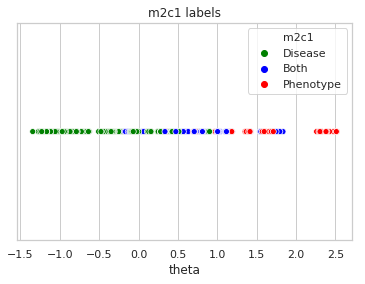

In [268]:
plot_thetas(pos, annotator_names[0])

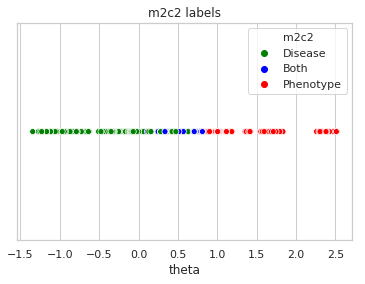

In [269]:
plot_thetas(pos, annotator_names[1])

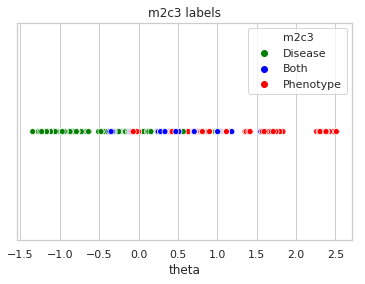

In [270]:
plot_thetas(pos, annotator_names[2])

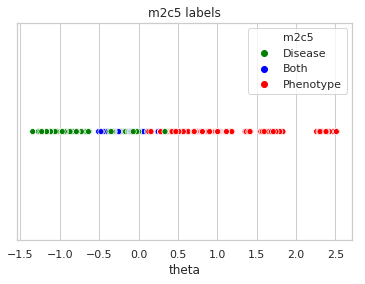

In [271]:
plot_thetas(pos, annotator_names[3])

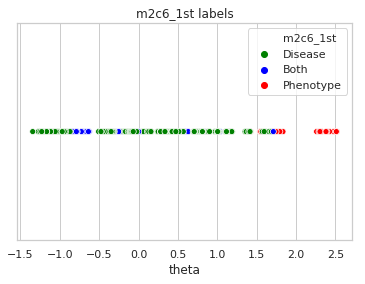

In [272]:
plot_thetas(pos, annotator_names[4])

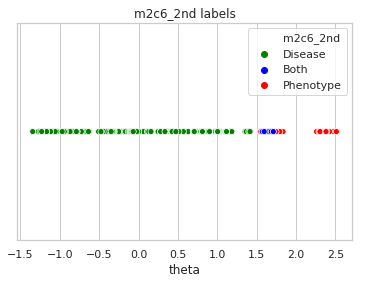

In [273]:
plot_thetas(pos, annotator_names[5])

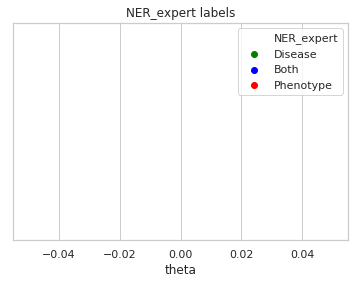

In [274]:
plot_thetas(pos, annotator_names[6])

In [275]:
xda, xdr = get_annotator_bias(avg_values['d_alpha'], avg_values['d_beta'])

In [276]:
xpa, xpr = get_annotator_bias(avg_values['p_alpha'], avg_values['p_beta'])

In [277]:
xda - xdr

array([-0.72339426, -1.43157962, -0.58791857, -1.27713534, -0.51926647,
       -0.3934975 ,  0.04532312])

In [278]:
xpa - xpr

array([0.9971594 , 1.18385787, 0.7358913 , 0.70020939, 0.21151144,
       0.53870499, 0.13125123])

In [279]:
(xda + xdr)/2

array([  1.4049335 ,   0.72888975,   1.11626744,   0.49192822,
         1.97273623,   2.1614164 , -14.52807142])

In [280]:
(xpa + xpr)/2

array([ 0.54862135,  0.49571443,  0.16775796, -0.24336443,  2.22974545,
        1.54221155, -0.76702166])

In [281]:
loc_pd = pd.DataFrame()
loc_pd['xda'] = xda
loc_pd['xdr'] = xdr
loc_pd['xpa'] = xpa
loc_pd['xpr'] = xpr
loc_pd['annotator'] = annotator_names

In [282]:
loc_pd

,xda,xdr,xpa,xpr,annotator
0,1.043236,1.766631,1.047201,0.050042,m2c1
1,0.013100,1.444680,1.087643,-0.096215,m2c2
2,0.822308,1.410227,0.535704,-0.200188,m2c3
3,-0.146639,1.130496,0.106740,-0.593469,m2c5
4,1.713103,2.232369,2.335501,2.123990,m2c6_1st
5,1.964668,2.358165,1.811564,1.272859,m2c6_2nd
6,-14.505410,-14.550733,-0.701396,-0.832647,NER_expert


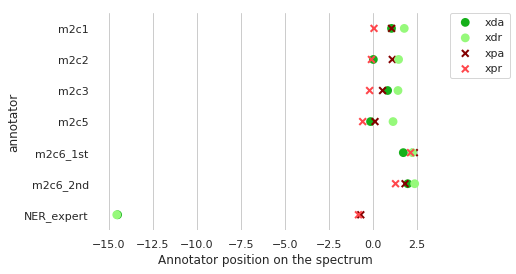

In [283]:
dis_pd = pd.DataFrame()
dis_pd['xda'] = xda
dis_pd['xdr'] = xdr
dis_pd['annotator'] = annotator_names

phe_pd = pd.DataFrame()
phe_pd['xpa'] = xpa
phe_pd['xpr'] = xpr
phe_pd['annotator'] = annotator_names
#'''

sns.set(style="whitegrid")

dis_pd = pd.melt(dis_pd, "annotator", var_name="measurement")
phe_pd = pd.melt(phe_pd, "annotator", var_name="measurement")

#print(dis_pd)
#print
#print(phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_pd, dodge=0, join=False,
              markers="o", scale=1, ci=None, palette=sns.xkcd_palette(["green", "light green"]))

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=phe_pd, dodge=0, join=False,
              markers="x", scale=1, ci=None, palette=sns.xkcd_palette(["dark red", "light red"]))

#ax.set_title('Annotator positions')
ax.set_xlabel('Annotator position on the spectrum')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [284]:
dis_loc = (xda + xdr)/2
phe_loc = (xpa + xpr)/2

phe_loc - dis_loc

array([-0.85631215, -0.23317531, -0.94850948, -0.73529265,  0.25700923,
       -0.61920485, 13.76104976])

[-1.38237205 -0.69852908 -1.70091582 -0.78300237 -1.92579352 -2.5413122
 22.0637928 ]


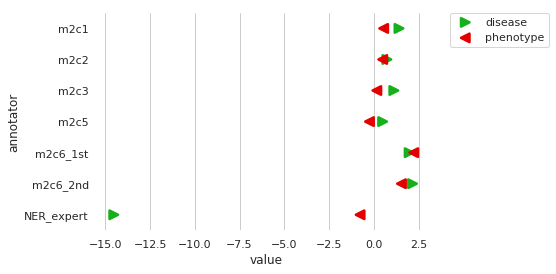

In [285]:
dis_phe_pd = pd.DataFrame()
dis_phe_pd['disease'] = dis_loc
dis_phe_pd['phenotype'] = phe_loc
dis_phe_pd['annotator'] = annotator_names

sns.set(style="whitegrid")

dis_phe_pd = pd.melt(dis_phe_pd, "annotator", var_name="measurement")

dis_phe_pd

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_phe_pd, dodge=0, join=False,
              markers=[">", "<"], scale=1.25, ci=None, palette=sns.xkcd_palette(['green', 'red']))

#ax.set(xticks=[-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5])
#ax.set(xticks=np.arange(np.floor(theta_min), np.ceil(theta_max), 0.5))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

dis_inverses = 1/(xda - xdr)
print(dis_inverses)

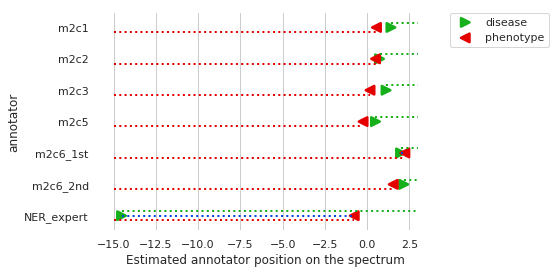

In [315]:
dis_phe_pd = pd.DataFrame()
dis_phe_pd['disease'] = dis_loc
dis_phe_pd['phenotype'] = phe_loc
dis_phe_pd['annotator'] = annotator_names

sns.set(style="whitegrid")

dis_phe_pd = pd.melt(dis_phe_pd, "annotator", var_name="measurement")

#print(dis_phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_phe_pd, dodge=0, join=False,
              markers=[">", "<"], scale=1.25, ci=None, palette=sns.xkcd_palette(['green', 'red']))

i = 0
for annotator in annotator_names:
    #annotator = 'Annotator{}'.format(i+1)
    dis = dis_phe_pd[(dis_phe_pd['annotator'] == annotator) & (dis_phe_pd['measurement'] == 'disease')]['value']
    
    phe = dis_phe_pd[(dis_phe_pd['annotator'] == annotator) & (dis_phe_pd['measurement'] == 'phenotype')]['value']
    
    plt.plot([dis, np.ceil(theta_max)], [i-0.15, i-0.15], sns.xkcd_rgb["green"], lw=2, linestyle=':')
    plt.plot([-15.0, phe], [i+0.15, i+0.15], sns.xkcd_rgb["red"], lw=2, linestyle=':')
    if dis.sum() < phe.sum():
        plt.plot([dis.sum(), phe.sum()], [i, i], sns.xkcd_rgb["blue"], lw=2, linestyle=':')
    i += 1

#ax.set(xticks=[-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5])
#ax.set(xticks=np.arange(np.floor(theta_min), np.ceil(theta_max)))
ax.set_xlabel('Estimated annotator position on the spectrum')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


Text(0,0.5,'Bias estimate for disease')

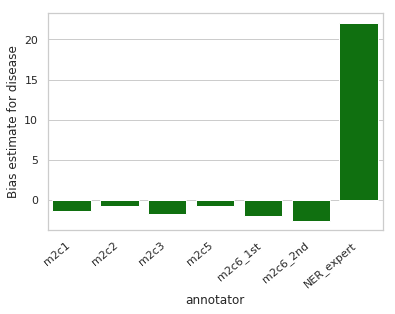

In [287]:
dis_inverses = 1/(xda - xdr)

dis_inverses_pd = pd.DataFrame()
dis_inverses_pd['error_bar'] = dis_inverses
dis_inverses_pd['annotator'] = annotator_names

ax = sns.barplot(x="annotator", y="error_bar", data=dis_inverses_pd, color="green")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_ylabel('Bias estimate for disease')

Text(0,0.5,'Bias estimate for phenotype')

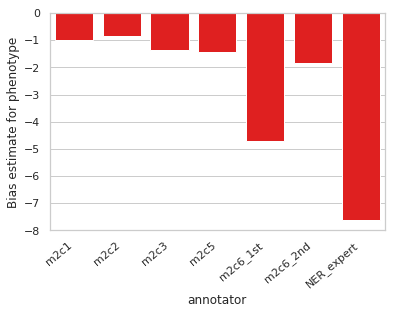

In [288]:
phe_inverses = 1/(xpr - xpa)

phe_inverses_pd = pd.DataFrame()
phe_inverses_pd['error_bar'] = phe_inverses
phe_inverses_pd['annotator'] = annotator_names

ax = sns.barplot(x="annotator", y="error_bar", data=phe_inverses_pd, color="red")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax.set_ylabel('Bias estimate for phenotype')

In [289]:
def plot_theta_tokens(pos_annos):
    pos_theta = pos[['Token', 'theta']]
    pos_theta['zeros'] = 0
    ax = sns.scatterplot(x="theta", y="zeros", data=pos_theta)

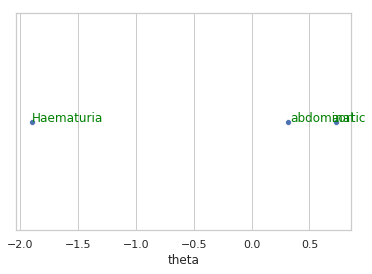

In [503]:
new_pos = pos[['Token', 'theta', 'zeros']][:3]
#plot_theta_tokens(pos)
ax = sns.scatterplot(x="theta", y="zeros", data=new_pos) #, \
                         #hue_order=['I-Disease', 'I-Disease_Pheno', 'I-Phenotype'], \
                         #palette={'I-Disease':'green', 'I-Phenotype':'red', 'I-Disease_Pheno':'blue'})
ax.get_yaxis().set_visible(False)

mult = -1
for line in range(0, new_pos.shape[0]):
    ax.text(new_pos.theta[line]+0.02*line*mult, \
             new_pos.zeros[line], new_pos.Token[line], \
             horizontalalignment = 'left', color='green')
    mult *= -1

In [308]:
def count_relevant_stats(relevant_annotations, annotator, label):
    return relevant_annotations[relevant_annotations[annotator] == label][annotator].count()

In [309]:
def get_relevant_stats(relevant_annotations, annotator):
    print 'Statistics for {}'.format(annotator)
    print 'Percentage of Disease labels: {}'.format(count_relevant_stats(relevant_annotations, annotator, 'I-Disease')/503.0)
    print 'Percentage of Phenotype labels: {}'.format(count_relevant_stats(relevant_annotations, annotator, 'I-Phenotype')/503.0)
    print 'Percentage of both labels: {}'.format(count_relevant_stats(relevant_annotations, annotator, 'I-Disease_Pheno')/503.0)

In [259]:
for annotator in annotator_names:
    get_relevant_stats(relevant_annotations, annotator)
    print

Statistics for files1
Percentage of Disease labels: 0.628230616302
Percentage of Phenotype labels: 0.105367793241
Percentage of both labels: 0.157057654076

Statistics for files2
Percentage of Disease labels: 0.62226640159
Percentage of Phenotype labels: 0.20675944334
Percentage of both labels: 0.0616302186879

Statistics for files3
Percentage of Disease labels: 0.500994035785
Percentage of Phenotype labels: 0.165009940358
Percentage of both labels: 0.224652087475

Statistics for files4
Percentage of Disease labels: 0.375745526839
Percentage of Phenotype labels: 0.268389662028
Percentage of both labels: 0.246520874751

Statistics for files5
Percentage of Disease labels: 0.789264413519
Percentage of Phenotype labels: 0.0715705765408
Percentage of both labels: 0.0298210735586

Statistics for files6
Percentage of Disease labels: 0.729622266402
Percentage of Phenotype labels: 0.065606361829
Percentage of both labels: 0.0954274353877

Statistics for NER_expert
Percentage of Disease labels: 